In [2]:
import dask.dataframe as dd
import dask_geopandas as dg

import pandas as pd
import geopandas as gpd
from siuba import *

from shared_utils import rt_dates

import gcsfs
fs = gcsfs.GCSFileSystem()

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [34]:
analysis_date = rt_dates.DATES['jan2023']

In [35]:
analysis_date

'2023-01-18'

In [37]:
partition_speeds = f'gs://calitp-analytics-data/data-analyses/rt_segment_speeds/speeds_{analysis_date}'

In [38]:
ddf = dd.read_parquet(partition_speeds)

In [39]:
ddf

,gtfs_dataset_key,_gtfs_dataset_name,trip_id,route_dir_identifier,segment_sequence,min_time,max_time,min_dist,max_dist,meters_elapsed,sec_elapsed,speed_mph
npartitions=6,,,,,,,,,,,,
,object,object,object,int64,object,"datetime64[ns, UTC]","datetime64[ns, UTC]",float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


In [40]:
ddf.isna().min_time.value_counts().compute()

False    1311292
Name: min_time, dtype: int64

In [41]:
ddf.isna().max_time.value_counts().compute()

False    1311292
Name: max_time, dtype: int64

In [42]:
ddf.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 12 entries, gtfs_dataset_key to speed_mph
dtypes: datetime64[ns, UTC](2), object(4), float64(5), int64(1)

In [43]:
ddf.max().compute()

gtfs_dataset_key        f1497340b654f3ce925f8b8c2f83e1c2
_gtfs_dataset_name             Yolobus Vehicle Positions
trip_id                              t_97725_b_2397_tn_9
route_dir_identifier                          4292426728
segment_sequence                                      99
min_time                       2023-01-18 23:59:42+00:00
max_time                       2023-01-18 23:59:43+00:00
min_dist                                          1000.0
max_dist                                          1000.0
meters_elapsed                                    1000.0
sec_elapsed                                     174950.0
speed_mph                                     983.242342
dtype: object

In [44]:
ddf.min().compute()

gtfs_dataset_key                         02af2d11f5bd44434c581540e9e857d8
_gtfs_dataset_name      Antelope Valley Transit Authority Vehicle Posi...
trip_id                              0049829c-505d-42db-965b-9ebd61bf1280
route_dir_identifier                                              1525250
segment_sequence                                                        0
min_time                                        2023-01-16 18:01:21+00:00
max_time                                        2023-01-17 01:46:02+00:00
min_dist                                                              0.0
max_dist                                                              0.0
meters_elapsed                                                        0.0
sec_elapsed                                                           0.0
speed_mph                                                             0.0
dtype: object

In [45]:
no_motion = ddf[ddf.meters_elapsed == 0.0].compute()

In [46]:
no_motion >> head(3)

,gtfs_dataset_key,_gtfs_dataset_name,trip_id,route_dir_identifier,segment_sequence,min_time,max_time,min_dist,max_dist,meters_elapsed,sec_elapsed,speed_mph
63,02af2d11f5bd44434c581540e9e857d8,LA DOT VehiclePositions,45-2086817,3142909629,19,2023-01-18 00:26:19+00:00,2023-01-18 00:26:19+00:00,482.207808,482.207808,0.0,0.0,NaN
156,02af2d11f5bd44434c581540e9e857d8,LA DOT VehiclePositions,45-2086824,3142909629,27,2023-01-18 02:39:38+00:00,2023-01-18 02:39:38+00:00,452.950162,452.950162,0.0,0.0,NaN
159,02af2d11f5bd44434c581540e9e857d8,LA DOT VehiclePositions,45-2086821,3142909629,27,2023-01-18 01:29:39+00:00,2023-01-18 01:29:39+00:00,482.337272,482.337272,0.0,0.0,NaN


In [61]:
no_motion.isna().speed_mph.value_counts()

True     68646
False    16735
Name: speed_mph, dtype: int64

In [51]:
no_motion >> count(_._gtfs_dataset_name) >> arrange (-_.n)

,_gtfs_dataset_name,n
40,LA Metro Bus Vehicle Positions,22260
55,San Diego Vehicle Positions,9128
11,Bay Area 511 Muni VehiclePositions,4847
41,LA Metro Rail Vehicle Positions,4635
34,Foothill Vehicle Positions,3858
...,...,...
51,PresidiGo VehiclePositions,23
68,WeHo Vehicle Positions,17
60,Tahoe Transportation Vehicle Positions,12
28,BruinBus Vehicle Positions,5


## Notes

* insufficient data segments aren't min_dist/max_dist nan, they're min_dist == max_dist
* if min_time also == max_time, speed_mph is nan, otherwise speed_mph is 0.0
    * about 75% nan, 25% zero speeds
    * zero speeds -- breakdowns, end of trips, etc...??
* approximately _6%_ of segments have insufficient data based on 1/18/23 data
    * much higher, ~30%, in prior 10/12/22 data

In [47]:
no_motion_count = no_motion.shape[0]
no_motion_count

85381

In [48]:
all_count = ddf.shape[0].compute()
all_count

1311292

In [49]:
no_motion_count / all_count

0.0651121184297624

## Speeds?

In [55]:
all_speeds = ddf.speed_mph.compute()

In [57]:
to_chart = all_speeds[all_speeds < 100]

<AxesSubplot:>

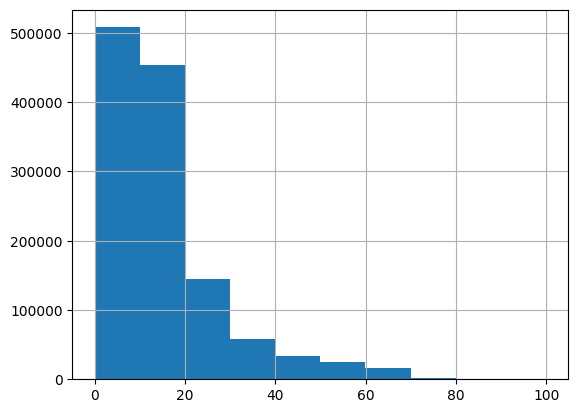

In [58]:
to_chart.hist()

In [ ]:
import pandas as pd
import geopandas as gpd
from siuba import *

from shared_utils import gtfs_utils_v2

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(1_000_000_000_000) ## 1TB?

In [6]:
gtfs_utils_v2?

Type:        module
String form: <module 'shared_utils.gtfs_utils_v2' from '/home/jovyan/data-analyses/_shared_utils/shared_utils/gtfs_utils_v2.py'>
File:        ~/data-analyses/_shared_utils/shared_utils/gtfs_utils_v2.py
Docstring:   GTFS utils for v2 warehouse


In [9]:
from calitp_data_analysis.tables import tbls

In [13]:
tbls.mart_transit_database.dim_gtfs_datasets() >> collect() >> filter(_.name.str.contains("Kings"))

,key,source_record_id,name,type,regional_feed_type,uri,future_uri,deprecated_date,data_quality_pipeline,manual_check__link_to_dataset_on_website,manual_check__accurate_shapes,manual_check__data_license,manual_check__authentication_acceptable,manual_check__stable_url,manual_check__localized_stop_tts,manual_check__grading_scheme_v1,base64_url,_is_current,_valid_from,_valid_to
115,e4562c470fe672741a94acda93746ddd,recwzZhQIinNX1KRp,Kings Schedule,schedule,None,https://kart.connexionz.net/rtt/public/utility...,None,None,True,Unknown,Yes,Missing,Yes,Yes - Vendor Website,Unknown,Unknown,aHR0cHM6Ly9rYXJ0LmNvbm5leGlvbnoubmV0L3J0dC9wdW...,True,2023-01-19 00:00:00+00:00,2098-12-31 23:59:59.999999+00:00
331,ca71fca800b4ddeeb95b3376be1749a1,recwzZhQIinNX1KRp,Kings Schedule,schedule,None,https://kart.connexionz.net/rtt/public/utility...,None,None,True,Unknown,Unknown,Unknown,Yes,Yes,Unknown,Unknown,aHR0cHM6Ly9rYXJ0LmNvbm5leGlvbnoubmV0L3J0dC9wdW...,False,2022-10-26 00:00:00+00:00,2022-11-21 23:59:59.999999+00:00
536,d58ff78d051be44f34bcbb2a168981db,recwzZhQIinNX1KRp,Kings Schedule,schedule,None,http://kart.connexionz.net/rtt/public/utility/...,None,None,True,Unknown,Unknown,Unknown,Yes,Yes,Unknown,Unknown,aHR0cDovL2thcnQuY29ubmV4aW9uei5uZXQvcnR0L3B1Ym...,False,2022-10-18 00:00:00+00:00,2022-10-25 23:59:59.999999+00:00
752,7863d3bb7214ea16fcb086e98cb23775,recwzZhQIinNX1KRp,Kings Schedule,schedule,None,https://kart.connexionz.net/rtt/public/utility...,None,None,True,Unknown,Unknown,Missing,Yes,Yes - Vendor Website,Unknown,Unknown,aHR0cHM6Ly9rYXJ0LmNvbm5leGlvbnoubmV0L3J0dC9wdW...,False,2022-11-22 00:00:00+00:00,2023-01-18 23:59:59.999999+00:00
1176,35932f2fc427b51841379d8fd178a394,recwzZhQIinNX1KRp,Kings Schedule,schedule,None,http://kart.connexionz.net/rtt/public/utility/...,None,None,True,None,None,None,None,None,None,None,aHR0cDovL2thcnQuY29ubmV4aW9uei5uZXQvcnR0L3B1Ym...,False,2022-06-29 00:00:00+00:00,2022-08-08 23:59:59.999999+00:00
1461,5c54e396094863c9db18039fd5cc817f,recwzZhQIinNX1KRp,Kings Schedule,schedule,None,http://kart.connexionz.net/rtt/public/utility/...,None,None,True,None,None,None,None,None,None,None,aHR0cDovL2thcnQuY29ubmV4aW9uei5uZXQvcnR0L3B1Ym...,False,2022-08-09 00:00:00+00:00,2022-10-17 23:59:59.999999+00:00
1838,a1d3e0db25b97c0aa87ece9d7c2de00d,recRJR8m0zlyHgLme,Kings Trip Updates,trip_updates,None,https://kart.connexionz.net/rtt/public/utility...,None,None,True,Unknown,Unknown,Unknown,Yes,Yes,Unknown,Unknown,aHR0cHM6Ly9rYXJ0LmNvbm5leGlvbnoubmV0L3J0dC9wdW...,False,2022-10-26 00:00:00+00:00,2022-11-21 23:59:59.999999+00:00
1863,69bf336494c273a143088764be02bf0b,recRJR8m0zlyHgLme,Kings Trip Updates,trip_updates,None,http://kart.connexionz.net/rtt/public/utility/...,None,None,True,Unknown,Unknown,Unknown,Yes,Yes,Unknown,Unknown,aHR0cDovL2thcnQuY29ubmV4aW9uei5uZXQvcnR0L3B1Ym...,False,2022-10-18 00:00:00+00:00,2022-10-25 23:59:59.999999+00:00
1952,55e824e4c88c4dfca7996b2c97f791c2,recRJR8m0zlyHgLme,Kings Trip Updates,trip_updates,None,https://kart.connexionz.net/rtt/public/utility...,None,None,True,Unknown,N/A - dataset type is not GTFS Schedule,Missing,Yes,Yes - Vendor Website,N/A - dataset type is not GTFS Schedule,N/A - dataset type is not GTFS Schedule,aHR0cHM6Ly9rYXJ0LmNvbm5leGlvbnoubmV0L3J0dC9wdW...,True,2023-01-14 00:00:00+00:00,2098-12-31 23:59:59.999999+00:00
2164,df187f048ef355f1017be80cb2ee4e12,recRJR8m0zlyHgLme,Kings Trip Updates,trip_updates,None,https://kart.connexionz.net/rtt/public/utility...,None,None,True,Unknown,Unknown,Missing,Yes,Yes - Vendor Website,Unknown,Unknown,aHR0cHM6Ly9rYXJ0LmNvbm5leGlvbnoubmV0L3J0dC9wdW...,False,2022-11-22 00:00:00+00:00,2023-01-13 23:59:59.999999+00:00


In [17]:
kings = gtfs_utils_v2.schedule_daily_feed_to_organization(selected_date = '2023-02-07') >> filter(_.name.str.contains("Kings"))
kings

,key,date,feed_key,base64_url,gtfs_dataset_key,is_future,name,regional_feed_type,type
130,b7212792b389a0df398c7bff6559b324,2023-02-07,99fca48844312a4b68af992be4f7ee43,aHR0cHM6Ly9rYXJ0LmNvbm5leGlvbnoubmV0L3J0dC9wdW...,e4562c470fe672741a94acda93746ddd,False,Kings Schedule,None,schedule


In [18]:
gtfs_utils_v2.get_trips(selected_date= '2023-02-07', operator_feeds=kings.feed_key.to_list()) 

DatabaseError: (google.cloud.bigquery.dbapi.exceptions.DatabaseError) 500 Query exceeded limit for bytes billed: 5000000000. 38576062464 or higher required.

Location: us-west2
Job ID: 31a7475d-651d-4cd7-a750-5d3e8e42efbe

[SQL: SELECT `anon_1`.`key`, `anon_1`.`service_date`, `anon_1`.`feed_key`, `anon_1`.`service_id`, `anon_1`.`name`, `anon_1`.`regional_feed_type`, `anon_1`.`trip_key`, `anon_1`.`trip_id`, `anon_1`.`trip_short_name`, `anon_1`.`direction_id`, `anon_1`.`block_id`, `anon_1`.`route_key`, `anon_1`.`route_id`, `anon_1`.`route_type`, `anon_1`.`route_short_name`, `anon_1`.`route_long_name`, `anon_1`.`route_desc`, `anon_1`.`agency_id`, `anon_1`.`network_id`, `anon_1`.`shape_array_key`, `anon_1`.`gtfs_dataset_key`, `anon_1`.`shape_id`, `anon_1`.`contains_warning_duplicate_trip_primary_key`, `anon_1`.`n_stops`, `anon_1`.`n_stop_times`, `anon_1`.`trip_first_departure_sec`, `anon_1`.`trip_last_arrival_sec`, `anon_1`.`service_hours`, `anon_1`.`contains_warning_duplicate_stop_times_primary_key`, `anon_1`.`contains_warning_missing_foreign_key_stop_id` 
FROM (SELECT `anon_2`.`key` AS `key`, `anon_2`.`service_date` AS `service_date`, `anon_2`.`feed_key` AS `feed_key`, `anon_2`.`service_id` AS `service_id`, `anon_2`.`name` AS `name`, `anon_2`.`regional_feed_type` AS `regional_feed_type`, `anon_2`.`trip_key` AS `trip_key`, `anon_2`.`trip_id` AS `trip_id`, `anon_2`.`trip_short_name` AS `trip_short_name`, `anon_2`.`direction_id` AS `direction_id`, `anon_2`.`block_id` AS `block_id`, `anon_2`.`route_key` AS `route_key`, `anon_2`.`route_id` AS `route_id`, `anon_2`.`route_type` AS `route_type`, `anon_2`.`route_short_name` AS `route_short_name`, `anon_2`.`route_long_name` AS `route_long_name`, `anon_2`.`route_desc` AS `route_desc`, `anon_2`.`agency_id` AS `agency_id`, `anon_2`.`network_id` AS `network_id`, `anon_2`.`shape_array_key` AS `shape_array_key`, `anon_2`.`gtfs_dataset_key` AS `gtfs_dataset_key`, `anon_2`.`shape_id` AS `shape_id`, `anon_2`.`contains_warning_duplicate_trip_primary_key` AS `contains_warning_duplicate_trip_primary_key`, `anon_2`.`n_stops` AS `n_stops`, `anon_2`.`n_stop_times` AS `n_stop_times`, `anon_2`.`trip_first_departure_sec` AS `trip_first_departure_sec`, `anon_2`.`trip_last_arrival_sec` AS `trip_last_arrival_sec`, `anon_2`.`service_hours` AS `service_hours`, `anon_2`.`contains_warning_duplicate_stop_times_primary_key` AS `contains_warning_duplicate_stop_times_primary_key`, `anon_2`.`contains_warning_missing_foreign_key_stop_id` AS `contains_warning_missing_foreign_key_stop_id` 
FROM (SELECT `anon_3`.`key` AS `key`, `anon_3`.`service_date` AS `service_date`, `anon_3`.`feed_key` AS `feed_key`, `anon_3`.`service_id` AS `service_id`, `anon_3`.`name` AS `name`, `anon_3`.`regional_feed_type` AS `regional_feed_type`, `anon_3`.`trip_key` AS `trip_key`, `anon_3`.`trip_id` AS `trip_id`, `anon_3`.`trip_short_name` AS `trip_short_name`, `anon_3`.`direction_id` AS `direction_id`, `anon_3`.`block_id` AS `block_id`, `anon_3`.`route_key` AS `route_key`, `anon_3`.`route_id` AS `route_id`, `anon_3`.`route_type` AS `route_type`, `anon_3`.`route_short_name` AS `route_short_name`, `anon_3`.`route_long_name` AS `route_long_name`, `anon_3`.`route_desc` AS `route_desc`, `anon_3`.`agency_id` AS `agency_id`, `anon_3`.`network_id` AS `network_id`, `anon_3`.`shape_array_key` AS `shape_array_key`, `anon_3`.`gtfs_dataset_key` AS `gtfs_dataset_key`, `anon_3`.`shape_id` AS `shape_id`, `anon_3`.`contains_warning_duplicate_trip_primary_key` AS `contains_warning_duplicate_trip_primary_key`, `anon_3`.`n_stops` AS `n_stops`, `anon_3`.`n_stop_times` AS `n_stop_times`, `anon_3`.`trip_first_departure_sec` AS `trip_first_departure_sec`, `anon_3`.`trip_last_arrival_sec` AS `trip_last_arrival_sec`, `anon_3`.`service_hours` AS `service_hours`, `anon_3`.`contains_warning_duplicate_stop_times_primary_key` AS `contains_warning_duplicate_stop_times_primary_key`, `anon_3`.`contains_warning_missing_foreign_key_stop_id` AS `contains_warning_missing_foreign_key_stop_id` 
FROM (SELECT `mart_gtfs.fct_daily_scheduled_trips_1`.`key` AS `key`, `mart_gtfs.fct_daily_scheduled_trips_1`.`service_date` AS `service_date`, `mart_gtfs.fct_daily_scheduled_trips_1`.`feed_key` AS `feed_key`, `mart_gtfs.fct_daily_scheduled_trips_1`.`service_id` AS `service_id`, `mart_gtfs.fct_daily_scheduled_trips_1`.`name` AS `name`, `mart_gtfs.fct_daily_scheduled_trips_1`.`regional_feed_type` AS `regional_feed_type`, `mart_gtfs.fct_daily_scheduled_trips_1`.`trip_key` AS `trip_key`, `mart_gtfs.fct_daily_scheduled_trips_1`.`trip_id` AS `trip_id`, `mart_gtfs.fct_daily_scheduled_trips_1`.`trip_short_name` AS `trip_short_name`, `mart_gtfs.fct_daily_scheduled_trips_1`.`direction_id` AS `direction_id`, `mart_gtfs.fct_daily_scheduled_trips_1`.`block_id` AS `block_id`, `mart_gtfs.fct_daily_scheduled_trips_1`.`route_key` AS `route_key`, `mart_gtfs.fct_daily_scheduled_trips_1`.`route_id` AS `route_id`, `mart_gtfs.fct_daily_scheduled_trips_1`.`route_type` AS `route_type`, `mart_gtfs.fct_daily_scheduled_trips_1`.`route_short_name` AS `route_short_name`, `mart_gtfs.fct_daily_scheduled_trips_1`.`route_long_name` AS `route_long_name`, `mart_gtfs.fct_daily_scheduled_trips_1`.`route_desc` AS `route_desc`, `mart_gtfs.fct_daily_scheduled_trips_1`.`agency_id` AS `agency_id`, `mart_gtfs.fct_daily_scheduled_trips_1`.`network_id` AS `network_id`, `mart_gtfs.fct_daily_scheduled_trips_1`.`shape_array_key` AS `shape_array_key`, `mart_gtfs.fct_daily_scheduled_trips_1`.`gtfs_dataset_key` AS `gtfs_dataset_key`, `mart_gtfs.fct_daily_scheduled_trips_1`.`shape_id` AS `shape_id`, `mart_gtfs.fct_daily_scheduled_trips_1`.`contains_warning_duplicate_trip_primary_key` AS `contains_warning_duplicate_trip_primary_key`, `mart_gtfs.fct_daily_scheduled_trips_1`.`n_stops` AS `n_stops`, `mart_gtfs.fct_daily_scheduled_trips_1`.`n_stop_times` AS `n_stop_times`, `mart_gtfs.fct_daily_scheduled_trips_1`.`trip_first_departure_sec` AS `trip_first_departure_sec`, `mart_gtfs.fct_daily_scheduled_trips_1`.`trip_last_arrival_sec` AS `trip_last_arrival_sec`, `mart_gtfs.fct_daily_scheduled_trips_1`.`service_hours` AS `service_hours`, `mart_gtfs.fct_daily_scheduled_trips_1`.`contains_warning_duplicate_stop_times_primary_key` AS `contains_warning_duplicate_stop_times_primary_key`, `mart_gtfs.fct_daily_scheduled_trips_1`.`contains_warning_missing_foreign_key_stop_id` AS `contains_warning_missing_foreign_key_stop_id` 
FROM `mart_gtfs.fct_daily_scheduled_trips` AS `mart_gtfs.fct_daily_scheduled_trips_1` 
WHERE `mart_gtfs.fct_daily_scheduled_trips_1`.`service_date` = %(service_date_1:STRING)s) AS `anon_3` 
WHERE `anon_3`.`feed_key` IN UNNEST(%(feed_key_1:STRING)s) OR `anon_3`.`name` IN UNNEST(%(name_1:STRING)s)) AS `anon_2`) AS `anon_1`]
[parameters: {'service_date_1': '2023-02-07', 'feed_key_1': ['99fca48844312a4b68af992be4f7ee43'], 'name_1': ['99fca48844312a4b68af992be4f7ee43']}]
(Background on this error at: https://sqlalche.me/e/14/4xp6)